## Linear Regression for Predicting Donated Value for Cash Appeals
This notebook applies statistical analysis, linear models, and evaluation metrics to a sample of supporters from the lapsed cash audience who responded to a fixed prompt cash ask. The data has been prepared in the jupyter notebook "3b Cash donations exploratory analysis" and imported as a CSV here.   

Linear regression has been used to predict the value of the supporters next cash donation.

### Importing the data 

In [1]:
import seaborn as sns 
sns.set_style ='white_grid'
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
%matplotlib inline
np.set_printoptions(suppress=True) 

In [2]:
df = pd.read_csv('//unicef-data/Data/Data/Fund/Public/Internal insight/Analysis/2017 Projects/K037 Cash Prompt Optimisation/3 Working files/K037_fixed_cash_cleaned.csv')

In [4]:
df.head()
df.dtypes

Unnamed: 0               int64
donatedamount          float64
lastdonationemer       float64
lastoneoffamount       float64
alldonationsavgl24m    float64
allltv                 float64
everpledgeflag         float64
lastoneoffga           float64
mosaicGroup             object
B                        int64
E                        int64
F                        int64
H                        int64
L                        int64
Mindful Mums             int64
Not in target            int64
Wealthy Wellwishers      int64
dtype: object

In [3]:
## Tidying up the data... 

##Exporting to CSV copied the pandas index field which isn't needed
df.drop('Unnamed: 0', axis = 1, inplace = True)

# converting binary flags from float to int 
df.everpledgeflag = df['everpledgeflag'].astype(int)
df.lastoneoffga = df['lastoneoffga'].astype(int)

# Found some nulls and filling them with 0
df.lastdonationemer.isnull().sum()
df['lastdonationemer'] = df['lastdonationemer'].fillna(0)
df['lastdonationemer'] = df['lastdonationemer'].astype(int)

## Combining some fields to see if these are more powerful than their individual parts
df['pct_last_to_avg24m'] = df.lastoneoffamount/df.alldonationsavgl24m
df['pct_last_to_avg24m'] = df['pct_last_to_avg24m'].fillna(0)

df['pct_last_to_all'] = df.lastoneoffamount/df.allltv
df['pct_last_to_all'] = df['pct_last_to_all'].fillna(0)

**Checking correlations and multi-collinearity**

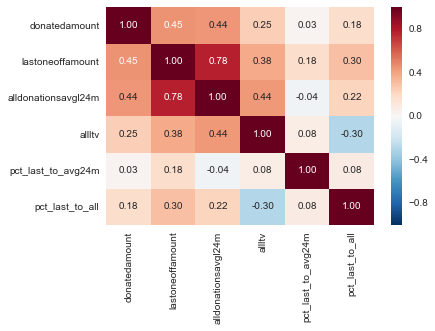

In [22]:
#Create correlation matrix for continuous variables.
cont_df= df.select_dtypes(include=[np.float64])
sns.heatmap(cont_df.corr(), annot=True, fmt='.2f')

There are some moderately correlated predictors with donated amount;  "Last one off amount" and "all donations average L24m" are the most correlated with donated amount, at 0.45 and 0.44, respectively.  Relatively low correlation suggests that the relationship between the predictors and outcome isn't truely linear which will effect the overall accuracy of a linear model.  I will challenge myself to achieve an r2 of 0.7 and test a non-linear model in a separate notebook.

Last one off amount is part of the last 24 months average and therefore these two variables are correlated (0.77),  I'll use a feature selection method (such as forward method) in the model build to see if additonal predictor/s improve the model.  

Once again, as "all donations avg L24m" is a subset of "all LTV" they are fairly correlated (0.435) with eachother.  It might be better to avoid features such as "allltv" which could weight older donors who've had more opportunity to give, this may not help with the prediction.

The newly created variable, pct_last_to_avg24m, has no correlation with donatedamount (0.02)

### Transforming the data   
The exploratory analysis showed that the data isn't normally distributed, as shown below. By logging the data I am hoping to create a more normal distribution that will improve the correlation and fit of a linear model. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010D17978>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000012585160>], dtype=object)

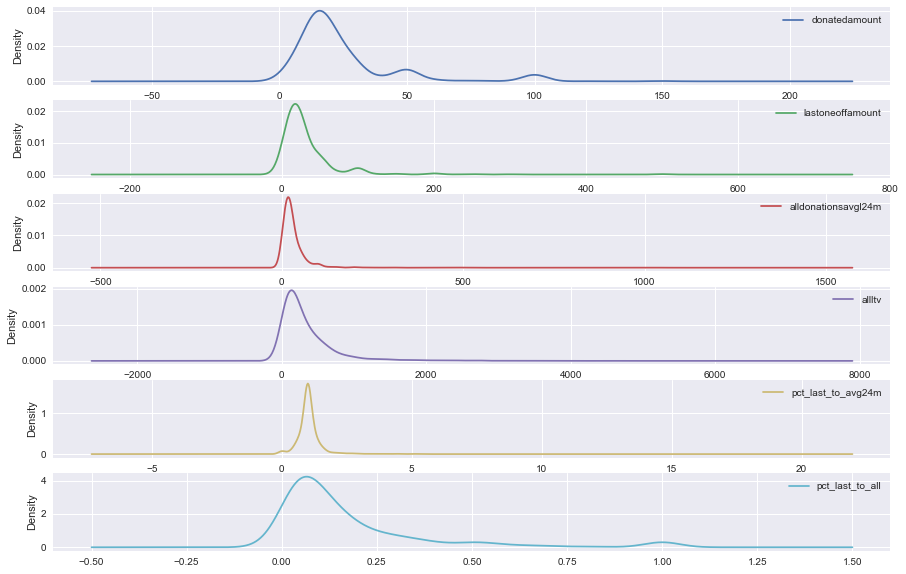

In [325]:
cont_df.plot(kind='density',subplots = True, sharey=False, sharex = False, figsize =(15,10))

In [5]:
#logging the dataframe that only contains continous variables.
log_df = cont_df.copy()
log_df = log_df.apply(np.log2)

Logging converts values that were 0 to minus infinity, showing in the data as "-inf"- these will cause the models to error.

In [8]:
log_df.columns

#there are 41 records which don't have any donation history
log_df[log_df.alldonationsavgl24m<0].count()

# A few spot checks... 
df[24:25]
# df[73:74]
# df[91:92]
# df[145:146]
df[318:319]

# df.donatedamount.mean()

,donatedamount,lastdonationemer,lastoneoffamount,alldonationsavgl24m,allltv,everpledgeflag,lastoneoffga,mosaicGroup,B,E,F,H,L,Mindful Mums,Not in target,Wealthy Wellwishers,pct_last_to_avg24m,pct_last_to_all
318,20.0,0,0.0,0.0,0.0,0.0,0.0,H,0,0,0,1,0,0,0,0,NaN,NaN


In [6]:
# overwriting -inf values with the mean in the pre-log data 
for column in cont_df: 
    cont_df[column][cont_df[column] ==0] = cont_df[column].mean()
    
# and then re-logging 
log_df = cont_df.copy()
log_df = log_df.apply(np.log2)   


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:4702: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
#checking a few examples 
cont_df[73:74]
cont_df[318:319]
log_df[318:319] #£20 = 4.32
log_df[73:74]#£10 = 3.32


,donatedamount,lastoneoffamount,alldonationsavgl24m,allltv,lastoneoffga,pct_last_to_avg24m,pct_last_to_all
73,3.321928,5.028172,4.998214,8.451674,-0.569291,NaN,NaN


In [88]:
print('**before**', cont_df.corr().donatedamount) 
print()
print('**after**', log_df.corr().donatedamount) 


**before** donatedamount          1.000000
lastoneoffamount       0.447849
alldonationsavgl24m    0.439678
allltv                 0.242552
pct_last_to_avg24m     0.020231
pct_last_to_all        0.176143
Name: donatedamount, dtype: float64

**after** donatedamount          1.000000
lastoneoffamount       0.661322
alldonationsavgl24m    0.668735
allltv                 0.305212
pct_last_to_avg24m     0.020010
pct_last_to_all        0.238709
Name: donatedamount, dtype: float64


Log transforming (both X and y) improves the correlation between each of the predictors and the outcome.

#### Visualising before and after...  
**Pre-log** last one off amount (correlation with outcome is 0.449)

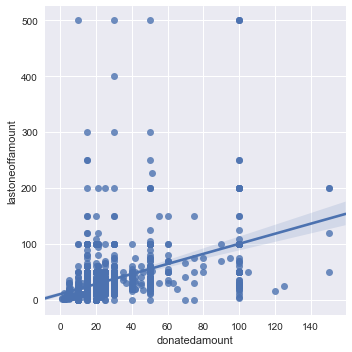

In [89]:
sns.lmplot('donatedamount', 'lastoneoffamount', df)

**post-log(2)** Last one off amount (correlation with outcome is 0.669)

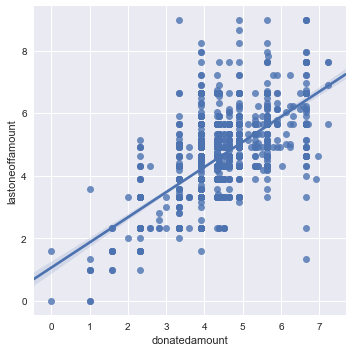

In [335]:
#log(10)
sns.lmplot('donatedamount', 'lastoneoffamount', log_df)

Below is confirmation of how the distribution is adjusted:

pre-log mean 24.889893446989877
pre-log mean 4.25760181628985


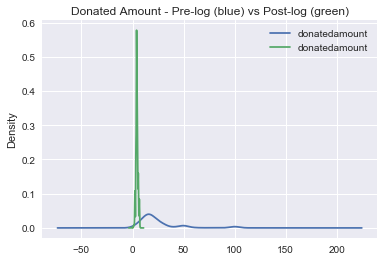

In [344]:
cont_df['donatedamount'].plot(kind ='density', legend = True, 
                              title = 'Donated Amount - Pre-log (blue) vs Post-log (green)')
log_df['donatedamount'].plot(kind ='density', legend = True)


print('pre-log mean', cont_df.donatedamount.mean())
print('pre-log mean', log_df.donatedamount.mean())

pre-log mean 33.34378343228419
post-log mean 4.484813098991557


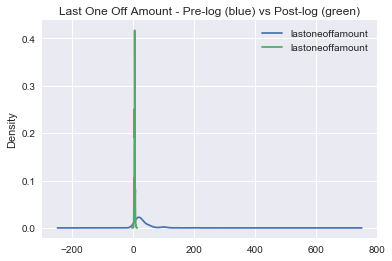

In [346]:
# log_df['donatedamount'].plot(kind ='density', legend = True, title = 'Post-log')
cont_df['lastoneoffamount'].plot(kind ='density', legend = True, 
                                 title = 'Last One Off Amount - Pre-log (blue) vs Post-log (green)') 
log_df['lastoneoffamount'].plot(kind ='density', legend = True)

print('pre-log mean', cont_df.lastoneoffamount.mean())
print('post-log mean', log_df.lastoneoffamount.mean())

### Simple regression to demonstrate the relationship between last one off amount and donated amount

In [7]:
import statsmodels.formula.api as smf

X = log_df[['lastoneoffamount']]#, 'alldonationsavgl24m', 'allltv','pct_last_to_avg24m', 'pct_last_to_all']]
y = log_df['donatedamount']

lm = smf.ols(formula='y ~ X', data=log_df).fit()

lm.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     1457.
Date:                Fri, 16 Jun 2017   Prob (F-statistic):          1.98e-236
Time:                        09:53:29   Log-Likelihood:                -2155.6
No. Observations:                1877   AIC:                             4315.
Df Residuals:                    1875   BIC:                             4326.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.8165      0.066     27.388      0.000         1.686     1.947
X              0.5443      0.014     38.176      0.000         0.516     0.572
==============================================================================
Omnibus:                       91.960   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.479
Skew:                           0.304   Prob(JB):                     6.53e-45
Kurtosis:                       4.494   Cond. No.                         18.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I ran a simple regression above to compare the lastoneoffamount to the donated amount.  
This tells me that for every £1 previously donated the current donation will increase by £1.46 (2^0.5443).  The y-intercept tells us that if the supporter didn't give previously then we could still expect £3.52 (2^1.8165). 

### Multiple linear regression

In [8]:
from sklearn import feature_selection, linear_model, metrics

** Comparing logged data vs original ** 

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


pvals: [ 0.          0.          0.          0.          0.38103012]
y-intercept: 14.8311563896
R-Squared: 0.231758026964
MSE: 363.354736048
Coefficients: [  0.11592938   0.09172192   0.00513132  10.38278233  -0.46693426]
pvals: [ 0.          0.          0.          0.          0.38626149]
y-intercept: 1.54666431629
R-Squared: 0.468622398064
MSE: 0.549820400035
Coefficients: [ -1.81818620e+13   1.92144249e+13  -1.03256293e+12  -1.03256293e+12
   1.92144249e+13]


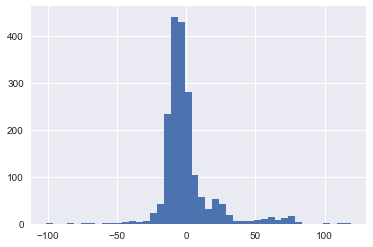

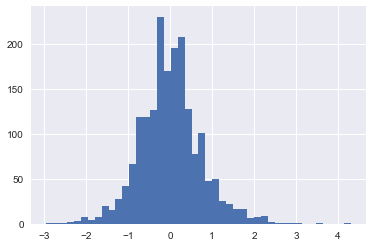

In [349]:
lm = linear_model.LinearRegression()

data = [cont_df, log_df]

for d in data:
    y = d['donatedamount']
    X= d[['lastoneoffamount', 'alldonationsavgl24m', 'allltv', 'pct_last_to_all']]#, 'pct_last_to_avg24m']]

    lm.fit(X, y)
    residuals = (y-lm.predict(X)).values #this captures the error between actual Y and predicted Y.
    pvals = feature_selection.f_regression(X, y)[1] # get the pvalue of X given y. 


    plt.figure()
    plt.hist(residuals, bins=np.ceil(np.sqrt(len(y))))
    print ('pvals:',pvals)
    print ('y-intercept:', lm.intercept_)
    print ('R-Squared:', lm.score(X,y))
    print('MSE:', metrics.mean_squared_error(y,lm.predict(X))) 
    print('Coefficients: {}'.format(lm.coef_))
    

The first two models compare the logged continous variables to the original.  

The second output relates to the logged data and shows an improvement in r2, from 0.232 to 0.469.  Both of these values are still quite low, and at best the linear model fits 0.469 of the data.  There's a considerable improvement in the MSE, from 363 to 0.54, this is illustrated in the plot of residuals, where the logged data shows a more desirable, normal distribution.  

pct_last_to_avg24m isn't statistically significant, and the high p value (0.38) suggests that the relationship between pct_last_to_avg24m and donated amount is random.  When removed the r2 value remains at 0.469 and the coefficients become more interpretable. For example, after removing pct_last_to_avg24m, for each £1 increase in donatedamount the lastoneoffamount increases by 0.85. Prior to removing pct_last_to_avg24m the coefficient for lastoneoffamount was -1.81...+e13.  

** Writing function to test different algortithms **

In [12]:
def get_linear_model_metrics(X, y, algo):
    pvals = feature_selection.f_regression(X, y)[1] # get the pvalue of X given y. 
         
    algo.fit(X,y)  # .fit() runs the linear regression function on X and y
    residuals = (y-algo.predict(X)).values

    # print the necessary values
    print('P Values:', pvals)
    print('Coefficients:', algo.coef_)
    print('y-intercept:', algo.intercept_)
    print('R-Squared:', algo.score(X,y))
    print('MSE:', metrics.mean_squared_error(y,algo.predict(X))) 
    plt.figure()
    plt.hist(residuals, bins=np.ceil(np.sqrt(len(y))))
    # keep the model
    return algo

** Adding the categorical features to the logged continuous variable to create model_df ** 

In [9]:
##Adding back in the categorical variables
df.columns
cols_to_keep = ['everpledgeflag', 'lastoneoffga','B', 'E', 'F', 'H', 'L', 'Mindful Mums', 'Not in target','Wealthy Wellwishers']
df_model = log_df
df_model= df_model.join(df[cols_to_keep]) 
df_model.drop('pct_last_to_avg24m', inplace=True, axis=1) # proven higher up that this has no correlation with donatedamount.
df_model.head(2)

,donatedamount,lastoneoffamount,alldonationsavgl24m,allltv,pct_last_to_all,everpledgeflag,lastoneoffga,B,E,F,H,L,Mindful Mums,Not in target,Wealthy Wellwishers
0,3.321928,3.321928,3.129283,6.000000,-2.678072,0,1,1,0,0,0,0,0,0,0
1,5.977280,4.906891,4.736962,9.451211,-4.544321,0,0,0,0,0,1,0,0,1,0


** Creating a training and test data set (80/20)** 

In [10]:
df_model.shape[0]*0.2
training_data = df_model [:1503]
test_data = df_model[:376]

Firstly I created a linear regression model (without any additional parameters) to understand the impact of adding the categorical features: 

Index(['lastoneoffamount', 'alldonationsavgl24m', 'allltv', 'pct_last_to_all',
       'everpledgeflag', 'lastoneoffga', 'B', 'E', 'F', 'H', 'L',
       'Mindful Mums', 'Not in target', 'Wealthy Wellwishers'],
      dtype='object')
P Values: [ 0.          0.          0.          0.          0.00451952  0.47949722
  0.00004847  0.00386207  0.00278687  0.04328553  0.00180245  0.01963812
  0.00000746  0.00000082]
Coefficients: [ 0.85936152  0.31298017 -0.58776343 -0.6016571   0.13272518 -0.0427394
  0.07064507 -0.08897303 -0.18447745 -0.14683832 -0.19720245  0.05439738
  0.03968155 -0.00768428]
y-intercept: 1.63936312252
R-Squared: 0.46909116558
MSE: 0.568059426372


C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


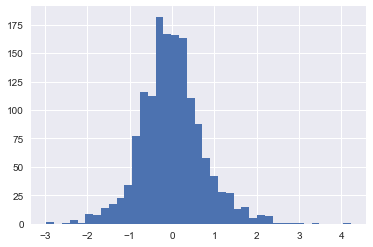

In [13]:
lm = linear_model.LinearRegression()
    
X = training_data.ix[0:, 1:]
y= training_data['donatedamount']

print(X.columns)
lm = get_linear_model_metrics(X, y, lm)

Adding in the categorical variables marginally improves the models ability to explain y - the r2 increases from 0.4625 to  0.4749.  

Running a linear model on the full data set confirms that the p values for lastoneoffga (0.39) and Mindful Mums (0.06) are too high (summarised below).  After dropping lastoneoffga and Mindful Mums and rerunning the model the r2 is 0.4747 and the MSE is 0.543 (although this would be the training set MSE)

In [137]:
##Sumarising p values:
pd.crosstab( X.columns, '', values=np.round(pvals,4), aggfunc='max').sort_values(ascending = False)

row_0
lastoneoffga           0.3940
Mindful Mums           0.0615
H                      0.0169
E                      0.0024
L                      0.0003
everpledgeflag         0.0002
F                      0.0001
pct_last_to_all        0.0000
lastoneoffamount       0.0000
allltv                 0.0000
alldonationsavgl24m    0.0000
Wealthy Wellwishers    0.0000
Not in target          0.0000
B                      0.0000
Name: __dummy__, dtype: float64

In [14]:
training_data.drop(['lastoneoffga', 'Mindful Mums'], inplace=True, axis=1)
test_data.drop(['lastoneoffga', 'Mindful Mums'], inplace=True, axis=1)

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


The exponential coefficients (summarised below) show that lastoneoffamount has the largest impact on donatedamount, and suggests for every £1 previously given there is an £1.76 effect on the current donation, all other features being the same.  

Each unit increase in pct_last_to_all reduces the donatedamount prediction, this makes logical sense, if the percentage is high then we can assume that the supporter hasn't made many donations and they're less engaged, whilst if the percentage is small, the donor might have been giving for sometime, be more engaged and therefore donate more.

In [365]:
pd.crosstab( X.columns, '', values=2**lm.coef_, aggfunc='max').sort_values(ascending = False)

row_0
lastoneoffamount       1.777314
alldonationsavgl24m    1.242554
everpledgeflag         1.095653
B                      1.048518
Not in target          1.025437
Wealthy Wellwishers    0.991623
E                      0.939576
H                      0.917406
F                      0.879041
L                      0.877932
allltv                 0.678564
pct_last_to_all        0.672226
Name: __dummy__, dtype: float64

### What effect does removing less powerful predictors from the model have?

**Recursive Feature Elimination** - Given the coefficients of a linear model, select features by recursively considering smaller and smaller sets of features.   
First, the estimator is trained on the initial set of features and coefficients are assigned. Then, features whose absolute weights (coefficients) are the smallest are pruned. That procedure is repeated until the desired number of features is reached - this is user defined.


In [15]:
from sklearn.feature_selection import RFE

model = linear_model.LinearRegression()
X = training_data.ix[0:, 1:] 
y= training_data['donatedamount']

# while n_features >2:
rfe = RFE(model, 1, step=1) 
rfe = rfe.fit(X, y)

print('n_features:', rfe.n_features_)
print(pd.crosstab(X.columns,'', values=rfe.ranking_, aggfunc='max').sort_values(ascending=True))


n_features: 1
row_0
lastoneoffamount        1
pct_last_to_all         2
allltv                  3
alldonationsavgl24m     4
F                       5
L                       6
everpledgeflag          7
H                       8
E                       9
B                      10
Not in target          11
Wealthy Wellwishers    12
Name: __dummy__, dtype: int32


The above confirms the coefficients and ranks the features which have least influence, those with coefficients close to zero, the lowest.  

<font color = red>What I was trying to test here is forward, backward and mixed selection methods, but I couldn't manage to write the code.  Are there any models which take this as a parameter? Where you don't specify the n_features, the model tells you which features shouldn't be included? <font/>

In [18]:
# Creating a dictionary containing the feature and rank from rfe
feature_rank= dict(zip(rfe.ranking_, X.columns)) 
# feature_rank

In [19]:
# Measuring the effect on r2 and MSE.
from sklearn import cross_validation

CV=cross_validation.KFold(n=len(df_model),n_folds=8)
n  = df_model.shape[1] # start with 14 features 

est = linear_model.LinearRegression() 
df_copy= training_data.copy()

while n >0:
#     X = df_model.ix[0:, 1:features] 
    features = [v for (k,v) in feature_rank.items() if k <=n]#this creates a list of features in rank order, rather than df order. 
    X = df_copy[features]
    est.fit(X,y)
    print('n_features: ',n,'MSE', metrics.mean_squared_error(y, est.predict(X)),
          'r2:',est.score(X,y)) #nb r2 will always be larger with more features.
    n -=1

n_features:  15 MSE 0.568509577377 r2: 0.468670454059
n_features:  14 MSE 0.568509577377 r2: 0.468670454059
n_features:  13 MSE 0.568509577377 r2: 0.468670454059
n_features:  12 MSE 0.568509577377 r2: 0.468670454059
n_features:  11 MSE 0.568521618772 r2: 0.468659200161
n_features:  10 MSE 0.568671934865 r2: 0.46851871461
n_features:  9 MSE 0.569056362225 r2: 0.468159428464
n_features:  8 MSE 0.569717218586 r2: 0.467541791534
n_features:  7 MSE 0.570275297572 r2: 0.467020210428
n_features:  6 MSE 0.570987949477 r2: 0.466354165338
n_features:  5 MSE 0.572198396531 r2: 0.465222880467
n_features:  4 MSE 0.573945110704 r2: 0.463590399881
n_features:  3 MSE 0.595676408392 r2: 0.443280310142
n_features:  2 MSE 0.602867713432 r2: 0.436559310191
n_features:  1 MSE 0.604500036708 r2: 0.435033739437


I hope that that above has a similar effect to a backwards selection method - considering all features and removing the least effective in each iteration.  
The results show that the first 4 features improve the r2, and additional features beyond this point provide a marginal gain. I could loosen my criteria and include the first 9 features, which each (roughly) improve r2 by 0.001.

In [20]:
features = ['lastoneoffamount', 'pct_last_to_all','allltv', 'alldonationsavgl24m','everpledgeflag','F','L','H','E']

### Calculating the optimum number of cross validation folds.

In [21]:
## see starter-code-7
from sklearn import cross_validation

est = linear_model.LinearRegression()
data = df_model.copy()
X = training_data[features]
y= training_data['donatedamount']

for i in range(2,20,1): #testing 2 to 20 
    kf = cross_validation.KFold(len(training_data), n_folds=i)#, shuffle=True) 
    mse= []
    
for train_index,test_index in kf:
    #build the model on the training set - does CV create train_index?
    lm = est.fit(X.iloc[train_index], y.iloc[train_index])
    # calculate MSE on test set, actual y vs predicted y on unseen data
    mse.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    print(np.mean(mse))

0.656985588852
0.589054249574
0.54750462983
0.582314596165
0.563689958494
0.551186252
0.524669570621
0.497633873916
0.48348299305
0.517423278175
0.519343414722
0.524899532428
0.548176347738
0.557109461774
0.5668971567
0.557769648243
0.578577987466
0.583164479982
0.580828362271


Initially I had set shuffle =True, this caused each run of the above code to result in different MSE values, (presumably because the folds are shuffled so each cut is different).  Turning shuffle off I think allows for better comparison between the k_folds.  

The lowest MSE (0.484) is achieved using 8 folds, which is an improvement compared to the 0.5432 MSE from the same model without using cross validation. I am quite surprised that the MSE has reduced, I would have expected it to increase when the model predicts on the unseen data set.  This suggests that the model is better able to predict the donated amount on the test dataset than it is on the training data set.

Why might the MSE decrease when we use CV?  The CV samples arent likely to show that much variation from the whole sample as you are only changing one fold at a time.  So the average MSE could increase or decrease, but you shouldn't see too much change.
<font color= red> Why isn't the second "for loop" indented? <font/>

### Testing different estimators

In [377]:
CV=cross_validation.KFold(n=len(training_data),n_folds=8)
estimators = [linear_model.LassoCV(cv=CV), ## lasso will reduce coefficients to 0 if the features aren't important
              linear_model.RidgeCV(cv=CV), # imposes a penalty on the size of the coefficient 
              linear_model.ElasticNetCV(cv=CV),
              linear_model.HuberRegressor()]# Colin suggested this might work better because I have a skewed distribution.
                                            # it sqs the error up to 1 std, and then increments linearly rather than exponential.

for est in estimators:
#     print (est)
    est.fit(X,y)
    print('MSE:', metrics.mean_squared_error(y, est.predict(X))) # this is training MSE.
    print('R-Squared:', est.score(X,y))
#     get_linear_model_metrics(X, y, est)
    print


MSE: 0.569421865117
R-Squared: 0.467817829143
MSE: 0.569122275514
R-Squared: 0.468097825847
MSE: 0.569792506186
R-Squared: 0.467471427677
MSE: 0.574171791953
R-Squared: 0.463378543388


At first glance, the Ridge estimator produces the lowest mean square error of 0.5691 (the mean of the squared residual errors) and the highest r2, 0.468.  

NB The MSE has been calculated from all data fed into the model rather than just the test dataset. As I am seeking to establish the best estimator at this point I am satisfied that combining the training and test MSE is still indicative of the models performance and using Cross Validation ensures that the models have been built with unseen data, it is just that the metric I am outputting isn't a test MSE.  The final model will be measured against an unseen test data set.  
  
  
<font color=red>Lasso reduces your feature count so it's good to use when the number of features exceeds the number of observations. </font>

### Regularisation 
Generalising the model by adding an error to the coefficients, to improve the models ability to explain an unseen y.

In [56]:
linear_model.Ridge().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])

In [380]:
## Grid Searching alpha values for the Ridge model. 

from sklearn import grid_search, cross_validation

X = training_data[features] #.ix[0:, 1:]
y= training_data['donatedamount']

alphas = np.logspace(-10, 10, 21)

gs = grid_search.GridSearchCV(
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas},
    cv=cross_validation.KFold(n=len(training_data),n_folds=8, shuffle=True),
    scoring = 'neg_mean_squared_error') 
    
gs.fit(X, y)

print (-gs.best_score_)  # prints the best(lowest) error for the TEST set.
print (gs.best_estimator_ )
for row in gs.grid_scores_:
    print (row)

0.5765858240094054
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
mean: -0.57666, std: 0.08216, params: {'alpha': 1e-10}
mean: -0.57666, std: 0.08216, params: {'alpha': 1.0000000000000001e-09}
mean: -0.57666, std: 0.08216, params: {'alpha': 1e-08}
mean: -0.57666, std: 0.08216, params: {'alpha': 9.9999999999999995e-08}
mean: -0.57666, std: 0.08216, params: {'alpha': 9.9999999999999995e-07}
mean: -0.57666, std: 0.08216, params: {'alpha': 1.0000000000000001e-05}
mean: -0.57666, std: 0.08216, params: {'alpha': 0.0001}
mean: -0.57666, std: 0.08216, params: {'alpha': 0.001}
mean: -0.57666, std: 0.08216, params: {'alpha': 0.01}
mean: -0.57665, std: 0.08210, params: {'alpha': 0.10000000000000001}
mean: -0.57659, std: 0.08155, params: {'alpha': 1.0}
mean: -0.57807, std: 0.07896, params: {'alpha': 10.0}
mean: -0.58368, std: 0.07727, params: {'alpha': 100.0}
mean: -0.60102, std: 0.07941, params: {'alpha': 1000.0}
m

The output shows the mean MSE of the kfolds for each alpha.  The smallest error, 0.5494, is achieved with an alpha of 1. 

The alphas are plotted below:

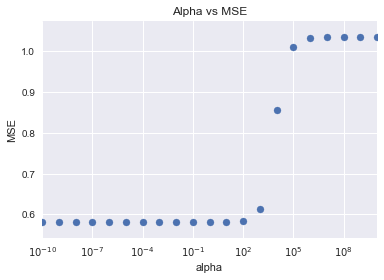

In [296]:
## plotting the alphas
alphas = np.logspace(-10, 10, 21) # use this to refine the range - np.arange(-4,-4,0.5) 
results=[]
for a in alphas:
    #print ('Alpha:', a)
    lm = linear_model.Ridge(alpha=a)
    lm.fit(X, y)
#     print (a,metrics.mean_squared_error(y, lm.predict(X)))
    results.append(metrics.mean_squared_error(y, lm.predict(X)))
    
plt.scatter(x=alphas,y=results)
plt.xlim(10**(-10),10**10)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Alpha vs MSE')
# plt.tick_params(axis='x', which='minor', color='red')

This graph confirms that an alpha of 1 catches the lower MSE's just before they rise aggressively.  

Finally, I have used the Gradient Descent technique to confirm the best alpha:

In [381]:
lm = linear_model.SGDRegressor() 
                                 
lm.fit(X, y) ## create the model
print ("This is the alpha:", lm.score(X, y))
print ("This is the MSE:", metrics.mean_squared_error(y, lm.predict(X)))

This is the alpha: 0.384547171087
This is the MSE: 0.658519426097


This shows with a more granular measurement that the best alpha is 0.38, but for simplicity I am going to stick with 1.

### Final model & Summary
Validating the final model on the test data set, using the parameters refined above.

In [23]:
lm = linear_model.RidgeCV(
    cv=cross_validation.KFold(n=len(training_data),n_folds=8, shuffle=True),
    alphas =range(1,2)) # this returns just 1 

X = ['lastoneoffamount', 'pct_last_to_all','allltv', 'alldonationsavgl24m','everpledgeflag','F','L','H','E']
y= ['donatedamount']

lm.fit(training_data[X],training_data[y])


print('intercept:', lm.intercept_) 
# print('features:', X) 
print('Coefficients:', lm.coef_) 
print('r2', lm.score(test_data[X],test_data[y]))
print('MSE', metrics.mean_squared_error(test_data[y], lm.predict(test_data[X])) )
# print(lm.alpha_)

intercept: [ 1.63768198]
Coefficients: [[ 0.7743851  -0.5203503  -0.50612046  0.31498905  0.12974203 -0.19478974
  -0.17103701 -0.13204056 -0.07428511]]
r2 0.526981696344
MSE 0.537761063671


When applying the model to the unseen test set it perfoms well and the r2 improves compared to the training model, from 0.468 to 0.526. The test MSE also decreases to 0.537 (vs the training_data 0.576).  

**Converting the logged values back to donated values ** 

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


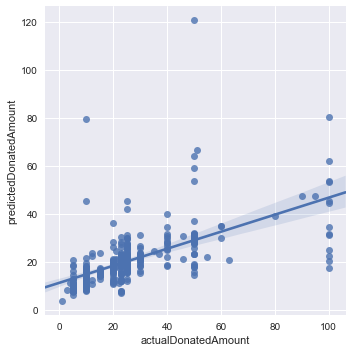

In [24]:
test_data['actualDonatedAmount'] = 2**test_data['donatedamount']
test_data['predictedDonatedAmount'] = 2**lm.predict(test_data[X])
# df_model.head()

sns.lmplot( 'actualDonatedAmount','predictedDonatedAmount', test_data)

The scatter plot shows that there are some sizeable errors, particularly as the actual donated amount increases the model struggles to predict the higher values. The data points at £100 actual donated amount  show that the data isn't linear - and a non-linear model such as random forest might perform better.  

The data points above the line and on the left hand side are perhaps the most concerning, this is where we're at risk of prompting the donor for an inflated amount, but they have only given £10 -20.  

Because of this risk it might be sensible to cap the predicted amount - depending on risk appetite, this could be at 1,2 or 3 standard deviations from the sample mean.

In [397]:
Y = test_data[['actualDonatedAmount', 'predictedDonatedAmount']]
print(Y.corr()['actualDonatedAmount'])
Y.describe().T

actualDonatedAmount       1.000000
predictedDonatedAmount    0.618692
Name: actualDonatedAmount, dtype: float64


,count,mean,std,min,25%,50%,75%,max
actualDonatedAmount,376.0,25.619681,20.100190,1.000000,10.000000,23.000000,30.000000,100.000000
predictedDonatedAmount,376.0,20.469173,11.523632,3.881859,13.252837,18.376971,23.205814,120.705796


The correlation between the predicted and actual donation is 0.61.  The correlation seen in the explanatory analysis between the actual donated amount and the mock variable prompt (what they would have got, if they weren't part of a fixed test) was 0.33.  

The summary statistics show that the mean predicted donation is c.£5 lower than the actual mean, in this use case, it is better to slightly under predict rather than over predict because there is evidence to suggest that high prompts discourage donating and the values will be  rounded before going into production. The variance from the predicted mean is also lower, given the scatter plot above this is expected, as we can see that the model doesn't predict the 'outlier' values as well - predicted values are more likely to be £40 or less.

** Plotting the residuals of the test set ** 

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


(array([  1.,   0.,   1.,   3.,   2.,   5.,   8.,  18.,  26.,  38.,  62.,
         77.,  49.,  41.,  25.,   4.,  11.,   1.,   2.,   2.]),
 array([-2.99294724, -2.71719833, -2.44144942, -2.16570051, -1.88995159,
        -1.61420268, -1.33845377, -1.06270486, -0.78695595, -0.51120704,
        -0.23545812,  0.04029079,  0.3160397 ,  0.59178861,  0.86753752,
         1.14328643,  1.41903534,  1.69478426,  1.97053317,  2.24628208,
         2.52203099]),
 <a list of 20 Patch objects>)

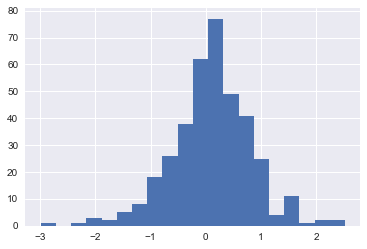

In [398]:
residuals = (test_data[y]-lm.predict(test_data[X])).values
plt.hist(residuals, bins=np.ceil(np.sqrt(len(test_data[y]))))

In [400]:
residuals.skew()

1.4557242093523801

The residuals are slightly skewed, and show that the actual donated amount is more likely to be greater than the predicted donation amount.  Aside from that, the residuals look relatively normal.

I also thought it might be interesting to plot the 'residuals' of the actual and predicted donation values after they've been converetd from their logged form:

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


(array([   2.,    0.,    0.,    0.,    1.,    0.,    1.,   13.,   95.,
         138.,   64.,   26.,   12.,    8.,    4.,    3.,    2.,    1.,
           2.,    4.]),
 array([-70.7057959 , -63.04099458, -55.37619327, -47.71139195,
        -40.04659063, -32.38178931, -24.71698799, -17.05218667,
         -9.38738535,  -1.72258403,   5.94221729,  13.60701861,
         21.27181993,  28.93662124,  36.60142256,  44.26622388,
         51.9310252 ,  59.59582652,  67.26062784,  74.92542916,  82.59023048]),
 <a list of 20 Patch objects>)

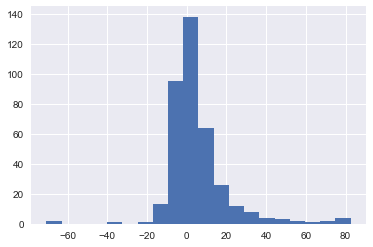

In [399]:
residuals  = (test_data['actualDonatedAmount']- test_data['predictedDonatedAmount'])
plt.hist(residuals, bins=np.ceil(np.sqrt(len(test_data['actualDonatedAmount']))))

In [438]:
residuals.mean()

5.150507615819313

This shows the skew more aggresively, although encouragingly c.230 of the 375 observations fall within +-£10 of the actual donation and the average difference between the actual and predicted donation is £5.15.

### Scorecard 
(Is that the right terminology?)

The best model I found used the following 9 features to predict the donated amount.  The table below shows the coeeficients with the corresponding £'s value:  
 
 
 |Feature| Description | Coefficient logged | £'s|
 |---|---|---|---|
 |intercept||1.62931036583|3.11|
|lastoneoffamount|| 0.7743851|1.71|
|pct_last_to_all||-0.5203503|0.70|
|allltv||-0.50612046|0.70|
|alldonationsavgl24m|| 0.31498905|1.24|
|everpledgeflag||0.12974203|1.09|
|F||-0.19478974|0.87|
|L||-0.17103701|0.89|
|H||-0.13204056|0.91|
|E||-0.07428511|0.95||

  
The **Ridge estimator** performed the best with an **alpha of 1**, cross validated on **8 folds** of data - meaning that the model was built 8 times and each time tested on 1/8th of unseen data.  

The resulting r2 tells us that **52.7%** of donated values can be explained by the model's features, which doesn't meet the 0.7 target I set myself.  The Mean Squared Error seems quite acceptable at **0.5377**, and the predicted donated amount is on average £5.15 less than the actual predicted amount.

** Next Steps **   

The sample size for this analysis is quite small and limited to "lapsed cash" donors, this causes me to have reservations on how representative it is of a wider more 'active' population.  After going through this analysis process and I am able to make recommendations on how we collect data going forward, which will improve the availability of training data and reduce bias.  

I could revisit the feature selection and prune more features, bearing in mind that additional features may complicate the maintenance of this model for very little gain.

I am also going to build a random forest model to see if a non-linear model can better fit the data.

In [421]:
#This was used for the table above
for c in lm.coef_: 
    print(c, np.round(2**c,2))
print(np.round(2**lm.intercept_,2))

[ 0.7743851  -0.5203503  -0.50612046  0.31498905  0.12974203 -0.19478974
 -0.17103701 -0.13204056 -0.07428511] [ 1.71  0.7   0.7   1.24  1.09  0.87  0.89  0.91  0.95]
[ 3.11]


### Update June 2017
Binning the predicted values so that they are comparable to the random forest model, which will allow me to evaluate both models using accuracy/ confusion matrix.

In [30]:
test_bins = test_data[['actualDonatedAmount', 'predictedDonatedAmount']]

bins = np.linspace(0,50, 6) # v2 

def add_bins(x):
    if np.all(x >bins[5]):
        return 5 
    elif np.all(x >bins[4]):
        return 4 
    elif np.all(x >bins[3]):
        return 3 
    elif np.all(x >bins[2]):
        return 2 
    elif np.all(x >bins[1]):
        return 1 
    else:
        return 0 

    
test_bins['predictedBin'] = test_data['predictedDonatedAmount'].map(add_bins)
test_bins['actualBin'] =test_data['actualDonatedAmount'].map(add_bins)

# 0, 0 to 9
# 1, 10 to 19 
# 2, 20 to 30 
# 5, 50+

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Axes(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

          0       0.88      0.27      0.41       105
          1       0.11      0.87      0.19        23
          2       0.58      0.42      0.49       153
          3       0.03      0.04      0.04        24
          4       0.12      0.02      0.04        49
          5       0.50      0.23      0.31        22

avg / total       0.54      0.32      0.35       376

accuracy 0.316489361702


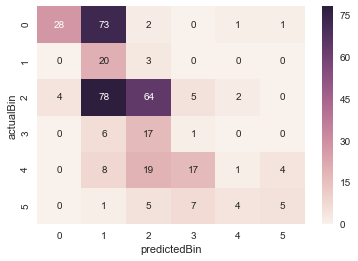

In [36]:
test_bins.head()

print(sns.heatmap(pd.crosstab(test_bins.actualBin,  #actual
                              test_bins.predictedBin) # prediction
                  ,annot= True))

from sklearn.metrics import classification_report,  accuracy_score

print(classification_report(test_bins.actualBin, test_bins.predictedBin))
print ('accuracy', accuracy_score(test_bins.actualBin, test_bins.predictedBin))

In [38]:
print(pd.crosstab(test_bins.actualBin,  #actual
                              test_bins.predictedBin) )

predictedBin   0   1   2   3  4  5
actualBin                         
0             28  73   2   0  1  1
1              0  20   3   0  0  0
2              4  78  64   5  2  0
3              0   6  17   1  0  0
4              0   8  19  17  1  4
5              0   1   5   7  4  5


The accuracy of the **random forest model is significantly higher** than the regression model here - 32% vs. 64%.

In [39]:
test_bins.actualDonatedAmount.mean()

25.61968085106383

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


376
mean residual 0.34308510638297873


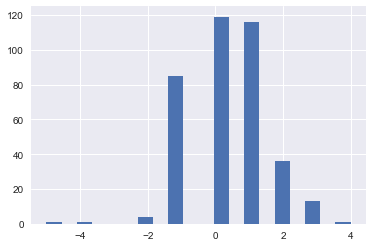

In [42]:
residuals = (test_bins.actualBin -test_bins.predictedBin)
plt.figure()
plt.hist(residuals, bins=np.ceil(np.sqrt(len(test_bins))))
print(len(test_bins))

print('mean residual', residuals.mean()) 

In [48]:
residuals.groupby(residuals).count()

-5      1
-4      1
-2      4
-1     85
 0    119
 1    116
 2     36
 3     13
 4      1
dtype: int64